<a href="https://colab.research.google.com/github/hzsrbi/Database_TarbiatModares/blob/main/Satellite_data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEE config

In [ ]:
from google.colab import auth
auth.authenticate_user(project_id='prefab-hull-448203-f7')

In [ ]:
import ee
ee.Authenticate()  # Run this to authenticate your account
ee.Initialize()

In [ ]:
# Load and filter GEDI data with time constraints
gedi = (
    ee.ImageCollection('LARSE/GEDI/GEDI02_A_002_MONTHLY')
    .select(['rh95', 'quality_flag', 'sensitivity'])  # Select RH95 and Quality Flag
    .filterBounds(edaratkol_fc)  # Filter to study area
    .filterDate('2022-01-01', '2023-12-29')  # Apply time filter
)

# Clip GEDI data to the region of interest and mosaic
gedi_mosaic = gedi.mosaic().clip(edaratkol_fc)

# Print GEDI dataset information
print(gedi_mosaic.getInfo())


{'type': 'Image', 'bands': [{'id': 'rh95', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'quality_flag', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'sensitivity', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


# Sentinel-1



1.   Calibration
2.   Terrain Flattening using external DEM (gives gamma0 images)
3.   (Range Doppler) Terrain Correction using same external DEM and projecting to UTM (gives gamma0, elevation, lat, lon, localIncidenceAngle, projectedIncidenceAngle, incidenceAngleFromEllipsoid)
4.   Convert gamma0 to gamma0 in dB






In [ ]:
import ee

# Initialize Earth Engine
ee.Initialize()

# Define the study area (edaratkol_fc) and date range
start_date = '2023-05-01'
end_date = '2023-05-30'

# Load Sentinel-1 GRD collection and apply time filter
s1 = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterBounds(edaratkol_fc) \
    .filterDate(start_date, end_date)  # Filter by the time range

# **Load & Process SRTM DEM for Terrain Correction**
srtm = ee.Image("USGS/SRTMGL1_003")  # Load SRTM 30m DEM
srtm_clipped = srtm.clip(edaratkol_fc)  # Clip DEM to study area
srtm_filtered = srtm_clipped  # No need for time filtering on SRTM data (static)
srtm_clean = srtm_filtered.toFloat().updateMask(srtm_filtered.neq(-32768))  # Convert to Float & Remove No-Data

# **Ensure VV and VH Bands Are Used**
polarization_bands = ['VV', 'VH']

# Filter only for the detected polarization type
s1 = s1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
s1 = s1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))

# **Function to Apply Thermal Noise Removal**
def thermal_noise_removal(image):
    return image.select(polarization_bands).subtract(image.select(['angle']).multiply(0.001))

# **Function to Apply Calibration**
def do_calibration(image, polarization, pols):
    return image.select(pols).divide(10.0).exp()

# **Function to Apply Speckle Filtering**
def do_speckle_filtering(image):
    return image.focal_mean(radius=3, kernelType='circle', iterations=1)

# **Function to Apply Terrain Correction**
def do_terrain_correction(image, proj, downsample):
    terrain_corrected = image.reproject(crs=proj, scale=40 if downsample else 10)
    return terrain_corrected

# Apply Preprocessing Steps
composite = (
    s1.filter(ee.Filter.eq('instrumentMode', 'IW'))  # IW mode for Interferometric Wide
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))  # Ascending orbit pass
    .map(thermal_noise_removal)
    .map(lambda img: do_calibration(img, 'VV', polarization_bands))
    .map(do_speckle_filtering)
    .map(lambda img: do_terrain_correction(img, 'EPSG:4326', downsample=1))
)

# **Check Number of Images Before Processing**
num_images = composite.size().getInfo()
print("✅ Number of Images Before Processing:", num_images)

# **Apply Median Reduction, Keeping All Bands**
s1_mosaic = composite.select(polarization_bands).median().clip(edaratkol_fc)

# **Fix Resolution by Reprojecting to Native Sentinel-1 Projection**
s1_mosaic = s1_mosaic.reproject(
    crs=s1.first().select(polarization_bands[0]).projection(),
    scale=10  # Sentinel-1 GRD IW native resolution
)

# **Check Final Resolution**
resolution = s1_mosaic.projection().nominalScale().getInfo()
print("✅ Final Corrected Output Image Resolution (meters):", resolution)


✅ Number of Images Before Processing: 27
✅ Final Corrected Output Image Resolution (meters): 10


# Sentinel-2

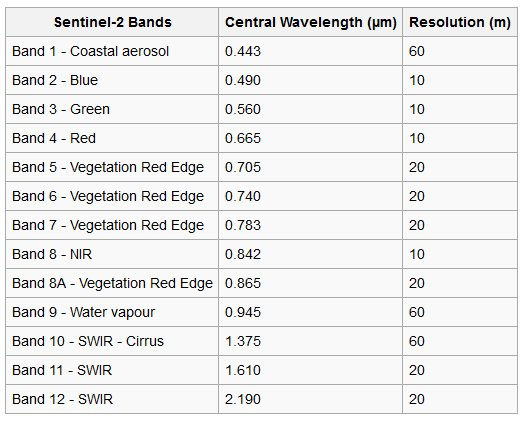

In [ ]:
import ee

# Initialize Earth Engine
ee.Initialize()

# Define the date range (ensure actual values are used)
start_date = "2023-05-01"
end_date = "2023-05-30"

# ✅ Correct path
s2 = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(edaratkol_fc)

# Function to apply additional atmospheric correction (Haze Reduction)
def apply_atmospheric_correction(image):
    # Group bands by resolution
    bands_10m = ["B2", "B3", "B4", "B8"]
    bands_20m = ["B5", "B6", "B7", "B8A", "B11", "B12"]

    # Select only spectral bands before correction
    image_10m = image.select(bands_10m)
    image_20m = image.select(bands_20m)

    # Compute the minimum value for haze removal (Dark Object Subtraction)
    haze_min_10m = image_10m.reduceRegion(
        reducer=ee.Reducer.percentile([2]),  # 2nd percentile for haze
        geometry=image.geometry(),
        scale=1000,
        bestEffort=True,
        tileScale=2
    )

    haze_min_20m = image_20m.reduceRegion(
        reducer=ee.Reducer.percentile([2]),  # 2nd percentile for haze
        geometry=image.geometry(),
        scale=2000,  # Adjust scale to match 20m resolution
        bestEffort=True,
        tileScale=2
    )

    # Ensure we get valid values for all bands (Avoiding null errors)
    def safe_get(haze_min, band_name):
        value = haze_min.get(band_name)
        return ee.Number(ee.Algorithms.If(value, value, 0))  # Default to 0 if null

    # Convert haze correction values into images at their respective resolutions
    correction_10m = ee.Image.cat([ee.Image.constant(safe_get(haze_min_10m, b)).rename(b) for b in bands_10m])
    correction_20m = ee.Image.cat([ee.Image.constant(safe_get(haze_min_20m, b)).rename(b) for b in bands_20m])

    # Subtract haze correction values (Matching bands exactly)
    corrected_10m = image_10m.subtract(correction_10m)
    corrected_20m = image_20m.subtract(correction_20m)

    # Ensure no negative values
    corrected_10m = corrected_10m.max(0)
    corrected_20m = corrected_20m.max(0)

    # Merge all corrected bands back into a single image
    corrected_image = corrected_10m.addBands(corrected_20m)

    return corrected_image.copyProperties(image, image.propertyNames())

# Function to mask clouds using Scene Classification Layer (SCL)
def mask_s2_clouds(image):
    scl = image.select("SCL")  # Sentinel-2 Scene Classification Layer

    # Mask out clouds, cirrus, shadows, and snow
    cloud_mask = scl.neq(3).And(  # Not cloud shadow
                   scl.neq(8)).And(  # Not clouds
                   scl.neq(9)).And(  # Not cirrus
                   scl.neq(10))  # Not snow

    # Apply cloud mask and divide by 10,000 to scale reflectance
    return image.updateMask(cloud_mask).divide(10000)

# Apply filters and corrections
composite = (
    s2.filterDate(start_date, end_date)
      .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 30))
      .map(mask_s2_clouds)
      .map(apply_atmospheric_correction)
      .map(lambda img: img.toFloat())  # ✅ Ensure all images are float
      .select(
          ["B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A"],
          ["S2_B11", "S2_B12", "S2_B2", "S2_B3", "S2_B4", "S2_B5", "S2_B6", "S2_B7", "S2_B8", "S2_B8A"]
      )
)


# Print the number of frames
num_frames = composite.size().getInfo()
print(f"✅ Number of Sentinel-2 Frames in Date Range: {num_frames}")

# Print information about the first corrected image
print("✅ First Processed Image Info:")
print(composite.first().getInfo())


✅ Number of Sentinel-2 Frames in Date Range: 89
✅ First Processed Image Info:
{'type': 'Image', 'bands': [{'id': 'S2_B11', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32640', 'crs_transform': [20, 0, 300000, 0, -20, 4100040]}, {'id': 'S2_B12', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32640', 'crs_transform': [20, 0, 300000, 0, -20, 4100040]}, {'id': 'S2_B2', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32640', 'crs_transform': [10, 0, 300000, 0, -10, 4100040]}, {'id': 'S2_B3', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32640', 'crs_transform': [10, 0, 300000, 0, -10, 4100040]}, {'id': 'S2_B4', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32640', 'crs_transform': [10, 0, 300000, 0, -10, 4100040]}, {'id': 'S2_

# Landsat

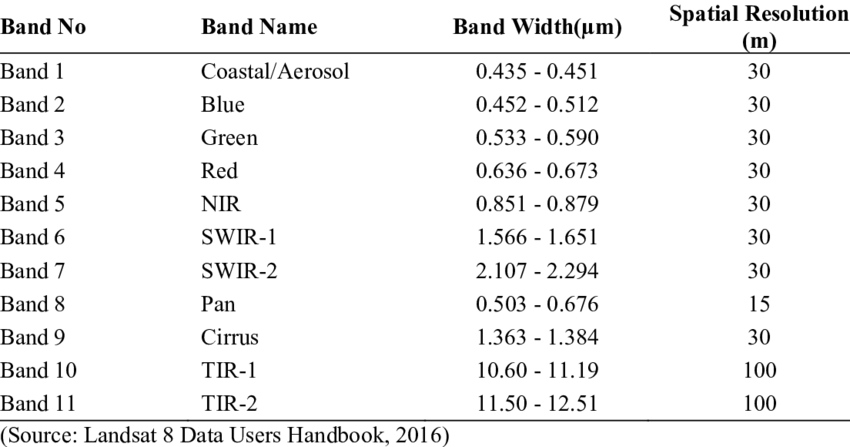

✅ Number of Landsat 8/9 Frames within AOI: 49


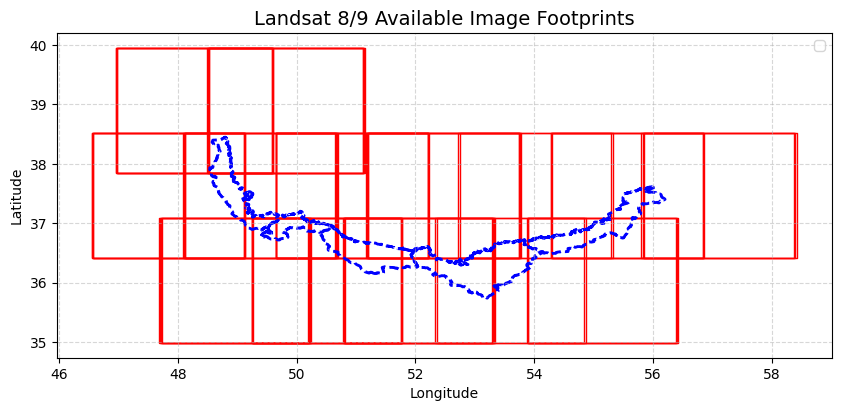

In [ ]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt

# Initialize Earth Engine
ee.Initialize()

# Define the region of interest (AOI)
roi = edaratkol_fc.geometry()

# Load and filter Landsat 8/9 Surface Reflectance Collection
landsat = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .merge(ee.ImageCollection("LANDSAT/LC09/C02/T1_L2"))
    .filterBounds(edaratkol_fc)  # ✅ Filter images within the study area
    .filterDate('2022-06-01', '2022-06-30')  # ✅ Filter by date (optional)
)

# Apply atmospheric correction
def apply_atmospheric_correction(image):
    corrected = image.multiply(0.0000275).add(-0.2)
    return corrected.copyProperties(image, image.propertyNames())

# Mask clouds & shadows
def mask_landsat_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_mask = 1 << 3  # Cloud bit (Bit 3)
    cloud_shadow_mask = 1 << 4  # Cloud shadow bit (Bit 4)
    return image.updateMask(qa.bitwiseAnd(cloud_mask).eq(0).And(qa.bitwiseAnd(cloud_shadow_mask).eq(0)))

# Rename bands
def rename_bands(image):
    new_band_names = {
        'SR_B2': 'L8_B2',  'SR_B3': 'L8_B3', 'SR_B4': 'L8_B4',
        'SR_B5': 'L8_B5', 'SR_B6': 'L8_B6', 'SR_B7': 'L8_B7'
    }
    return image.select(list(new_band_names.keys())).rename(list(new_band_names.values()))

# Extract image footprints
def get_image_bounds(image):
    return ee.Feature(image.geometry().bounds())

# Process Landsat data (filter, mask, correct, rename)
landsat_corrected = landsat.map(mask_landsat_clouds).map(apply_atmospheric_correction).map(rename_bands)

# Convert ImageCollection to FeatureCollection of bounding boxes
image_bounds_fc = ee.FeatureCollection(landsat_corrected.map(get_image_bounds))

# Count the number of available Landsat images
num_frames = image_bounds_fc.size().getInfo()
print(f"✅ Number of Landsat 8/9 Frames within AOI: {num_frames}")

# Convert image footprints & AOI to GeoDataFrames for visualization
image_bounds_gdf = gpd.GeoDataFrame.from_features(geemap.ee_to_geojson(image_bounds_fc))
aoi_gdf = gpd.GeoDataFrame.from_features(geemap.ee_to_geojson(edaratkol_fc))

# Plot Landsat image footprints
fig, ax = plt.subplots(figsize=(10, 8))
image_bounds_gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1, label="Landsat 8/9 Frames")
aoi_gdf.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=2, linestyle="dashed", label="AOI Boundary")

# Map styling
ax.set_title("Landsat 8/9 Available Image Footprints", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Show the static plot
plt.show()


# Meta Global Canopy Height

In [ ]:
import ee

# Initialize Earth Engine
ee.Initialize()

# Load the Canopy Height ImageCollection
canopy_collection = ee.ImageCollection('projects/meta-forest-monitoring-okw37/assets/CanopyHeight')

# Get the first image (assuming it has the correct projection)
first_image = canopy_collection.first()

# Extract the projection and scale
original_projection = first_image.projection()
original_crs = original_projection.crs()
original_scale = original_projection.nominalScale()

# Mosaic and explicitly set projection to match the original image
canopy_height = canopy_collection.mosaic().setDefaultProjection(original_crs, None, original_scale)

# Check the resolution and projection again
projection = canopy_height.projection()
scale = projection.nominalScale()

# Print final results
print("Final Corrected Resolution (Scale) of canopy_height:", scale.getInfo(), "meters")
print("Final Projection info:", projection.getInfo())


Final Corrected Resolution (Scale) of canopy_height: 1.194328566955889 meters
Final Projection info: {'type': 'Projection', 'crs': 'EPSG:3857', 'transform': [1.194328566955889, 0, 0, 0, -1.194328566955889, 0]}


# ETH Global canopy height

In [ ]:
import ee

# Initialize the Earth Engine module
ee.Initialize()

# Load the Canopy Height dataset
eth_canopy_height = ee.Image('users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1')

# Visualization settings
viz_params = {
    'min': 0,
    'max': 25,
    'palette': ['440154', '3b528b', '21918c', '5ec962', 'fde725']  # Equivalent to viridis[7]
}

# Display the layer (if using a map, e.g., folium)
import folium
import geemap

# Create a map centered at a specific location
Map = geemap.Map(center=[0, 0], zoom=3)

# Add the canopy height layer to the map
Map.addLayer(eth_canopy_height, viz_params, 'Canopy Height Lang 2022 98%')

# Display the map
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…